In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from numpy import unique, where
from collections import Counter
from sklearn.cluster import DBSCAN, KMeans
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import torch

import sys
sys.path.append("..")
from util.author_vis import t_sne, pca
from util.style_model import StyleModel
from util.clustering_eval import clustering_summary, print_clustering_classes

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_data = pd.read_pickle('../data/04c_Test_Set.pkl')

# Style Embeddings from Style Model

In [3]:
model = StyleModel()
model.load_state_dict(torch.load('../model/Style_Model.pt'))

<All keys matched successfully>

In [4]:
messages = test_data["message"].tolist()

vectors = []

for message in tqdm(messages):
    vectors.append(model(message).squeeze().detach().numpy())

vectors = np.array(vectors)

100%|██████████| 10684/10684 [02:51<00:00, 62.15it/s]


## Centroids

In [5]:
authors_centroids = {}

for group in test_data.groupby('author_email'):
    author_embeddings = np.array(vectors[group[1].index])
    authors_centroids[group[0]] = np.mean(author_embeddings, axis = 0)

In [6]:
centroids_array = [value for value in authors_centroids.values()]

distances = pd.DataFrame(euclidean_distances(centroids_array, centroids_array))

for i in range(len(distances)):
    for j in range(i + 1):
        distances[j][i] = 0

distances.style.background_gradient(cmap='coolwarm').set_precision(3)

,0,1,2,3,4,5,6
0,0.000,0.258,0.218,0.441,0.207,0.319,0.280
1,0.000,0.000,0.277,0.461,0.287,0.360,0.305
2,0.000,0.000,0.000,0.440,0.182,0.244,0.216
3,0.000,0.000,0.000,0.000,0.449,0.483,0.445
4,0.000,0.000,0.000,0.000,0.000,0.268,0.204
5,0.000,0.000,0.000,0.000,0.000,0.000,0.178
6,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## PCA & t-SNE Visualizations

First, the generated vectors are reduced to two and three dimensions with PCA and t-SNE and visualized. Each of the seven authors gets a different color.

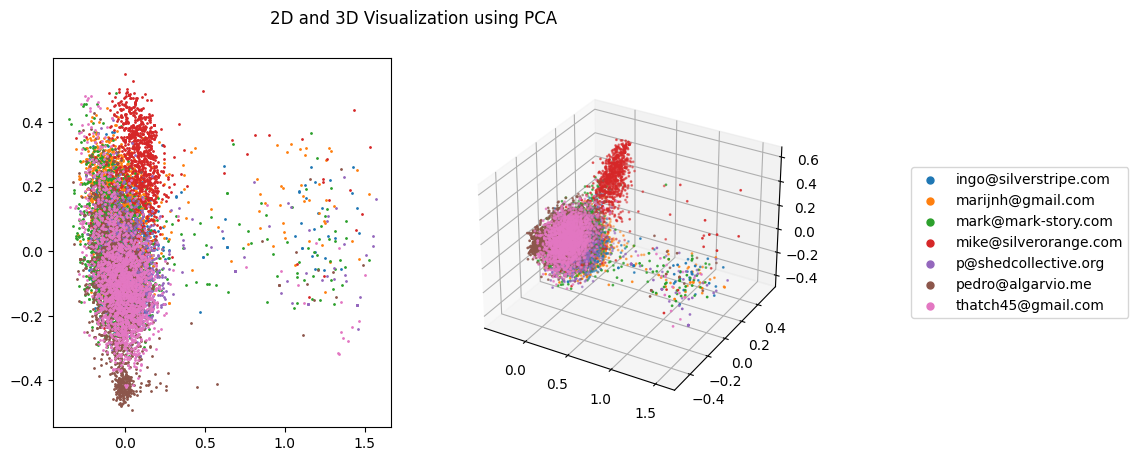

In [7]:
pca_2_prediction, pca_3_prediction = pca(vectors, test_data)

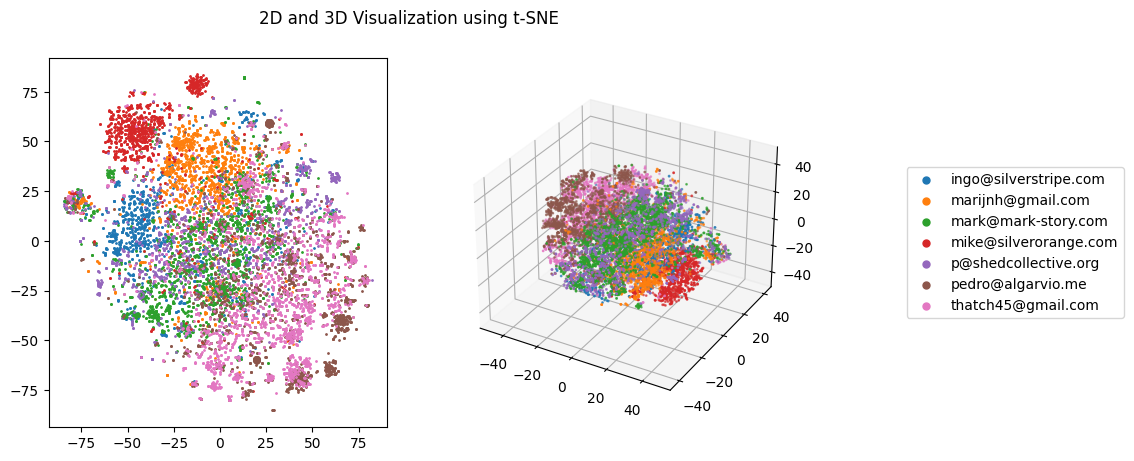

In [8]:
t_sne_2_prediction, t_sne_3_prediction = t_sne(vectors, test_data)

## DBSCAN

% TODO: - Describe DBSCAN: Density-based, no number of clusters needed, ability to provide min_samples to make one cluster

Number of Clusters: 2
10 Most common:
[(0, 9650), (-1, 1034)]


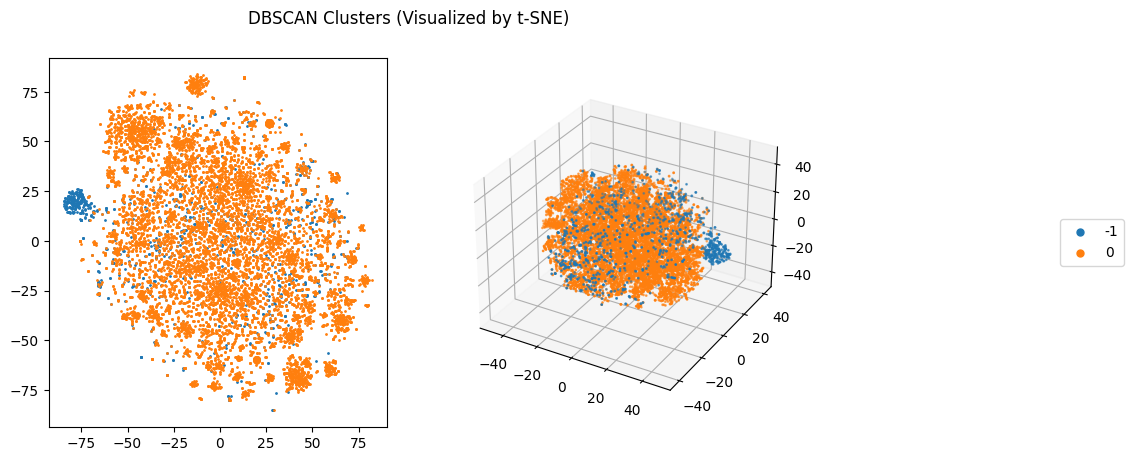

In [9]:
dbscan_model = DBSCAN(eps=1, min_samples=50)
dbscan_prediction = dbscan_model.fit_predict(vectors)

dbscan_clusters = unique(dbscan_prediction)

print(f"Number of Clusters: {len(dbscan_clusters)}")
print("10 Most common:")
print(Counter(dbscan_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for dbscan_cluster in dbscan_clusters:
    index = where(dbscan_prediction == dbscan_cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=dbscan_cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=dbscan_cluster)

fig.suptitle("DBSCAN Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [10]:
dbscan_summary = clustering_summary(dbscan_prediction, test_data)
dbscan_summary

There are 7 different authors.
There are 91 different projects.


,Number of Messages,Number of different Authors,Average number of commits per different Author,Most common Author,Number of different Projects,Average number of commits per different Project,Most common project
0,1034.0,7.0,147.714286,"('p@shedcollective.org', 268)",58.0,17.827586,"('saltstack_salt', 300)"
1,9650.0,7.0,1378.571429,"('mark@mark-story.com', 1918)",89.0,108.426966,"('saltstack_salt', 3498)"


In [11]:
dbscan_summary.describe()

,Number of Messages,Number of different Authors,Average number of commits per different Author,Number of different Projects,Average number of commits per different Project
count,2.000000,2.0,2.000000,2.00000,2.000000
mean,5342.000000,7.0,763.142857,73.50000,63.127276
std,6092.432027,0.0,870.347432,21.92031,64.063436
min,1034.000000,7.0,147.714286,58.00000,17.827586
25%,3188.000000,7.0,455.428571,65.75000,40.477431
50%,5342.000000,7.0,763.142857,73.50000,63.127276
75%,7496.000000,7.0,1070.857143,81.25000,85.777121
max,9650.000000,7.0,1378.571429,89.00000,108.426966


In [12]:
print_clustering_classes(dbscan_prediction, test_data)


________________ Class 0 ________________

___
1) 
Set omnipay response earlier in PurchaseService

It might be used in onCaptured callbacks
___
2) 
Better shell execution feedback from PDF extractor
___
3) 
mlanthaler: Refactored the created code since the coding conventions for static methods were changed (ticket #<I>). 
(merged from branches/gsoc)


git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/sapphire/trunk@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
4) 
mlanthaler: Refactored the created code since the coding conventions for static methods were changed (ticket #<I>). 
(merged from branches/gsoc)


git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/sapphire/trunk@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
5) 
Added getters for http client/response
___
6) 
BUG Exclude meta info from SolrCell content retrieval

Was matching </str> greedily, which included too much content
___
7) 
Removed AddToCampaignHandler->setShowTitle()

It was used to supp

## K-Means

Centroid-Based, fixed number of Clusters

Goal: Find seven clusters for seven authors

Number of Clusters: 7
10 Most common:
[(3, 3094), (1, 2664), (6, 1753), (2, 1331), (4, 865), (5, 759), (0, 218)]


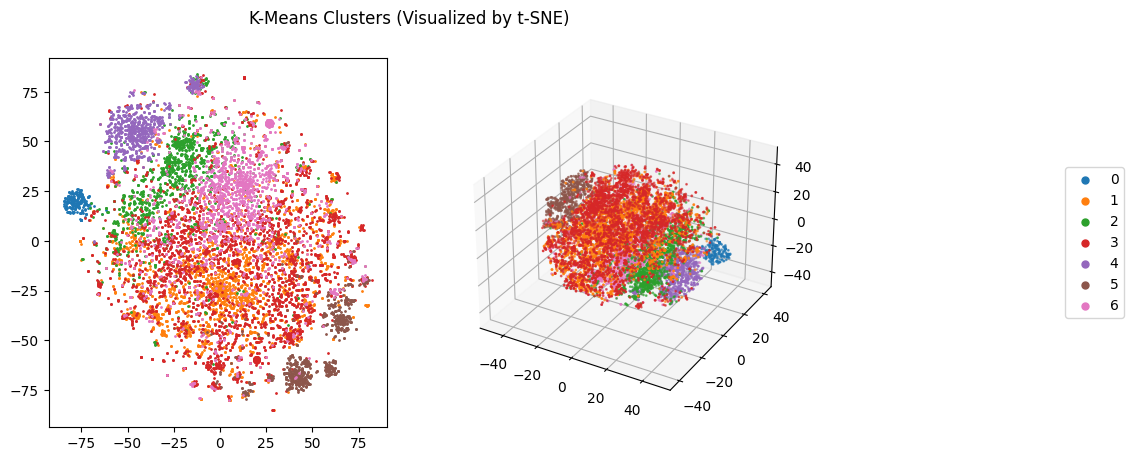

In [13]:
kmeans = KMeans(7)
kmeans_prediction = kmeans.fit_predict(vectors)

kmeans_clusters = unique(kmeans_prediction)

print(f"Number of Clusters: {len(kmeans_clusters)}")
print("10 Most common:")
print(Counter(kmeans_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for cluster in kmeans_clusters:
    index = where(kmeans_prediction == cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=cluster)

fig.suptitle("K-Means Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [14]:
kmeans_summary = clustering_summary(kmeans_prediction, test_data)
kmeans_summary

There are 7 different authors.
There are 91 different projects.


,Number of Messages,Number of different Authors,Average number of commits per different Author,Most common Author,Number of different Projects,Average number of commits per different Project,Most common project
0,218.0,7.0,31.142857,"('mark@mark-story.com', 51)",34.0,6.411765,"('cakephp_cakephp', 50)"
1,2664.0,7.0,380.571429,"('mark@mark-story.com', 866)",73.0,36.493151,"('saltstack_salt', 956)"
2,1331.0,7.0,190.142857,"('marijnh@gmail.com', 661)",43.0,30.953488,"('codemirror_CodeMirror', 562)"
3,3094.0,7.0,442.000000,"('thatch45@gmail.com', 924)",73.0,42.383562,"('saltstack_salt', 1423)"
4,865.0,6.0,144.166667,"('mike@silverorange.com', 825)",8.0,108.125000,"('silverorange_swat', 824)"
5,759.0,4.0,189.750000,"('pedro@algarvio.me', 507)",8.0,94.875000,"('saltstack_salt', 735)"
6,1753.0,7.0,250.428571,"('marijnh@gmail.com', 450)",54.0,32.462963,"('saltstack_salt', 584)"


In [15]:
kmeans_summary.describe()

,Number of Messages,Number of different Authors,Average number of commits per different Author,Number of different Projects,Average number of commits per different Project
count,7.000000,7.000000,7.000000,7.000000,7.000000
mean,1526.285714,6.428571,232.600340,41.857143,50.243561
std,1047.162470,1.133893,140.300824,27.211692,36.974231
min,218.000000,4.000000,31.142857,8.000000,6.411765
25%,812.000000,6.500000,166.958333,21.000000,31.708226
50%,1331.000000,7.000000,190.142857,43.000000,36.493151
75%,2208.500000,7.000000,315.500000,63.500000,68.629281
max,3094.000000,7.000000,442.000000,73.000000,108.125000


In [16]:
print_clustering_classes(kmeans_prediction, test_data)


________________ Class 0 ________________

___
1) 
mlanthaler: Refactored the created code since the coding conventions for static methods were changed (ticket #<I>). 
(merged from branches/gsoc)


git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/sapphire/trunk@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
2) 
mlanthaler: Refactored the created code since the coding conventions for static methods were changed (ticket #<I>). 
(merged from branches/gsoc)


git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/sapphire/trunk@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
3) 
BUGFIX More solid checks in Subsite permission methods to deal with non-existing members
___
4) 
Fixed DB quoting (mainly for non-MySQL compat)
___
5) 
Allow custom preview URLs through hidden fields

Useful e.g. to force non-SSL previews via absolute links,
even if the CMS is loaded on an SSL host.
___
6) 
MINOR Using SapphireInfo non-statically in RestfulService (fixes #<I>)
___
7) 
FIX Gr